# Heralded Preparation of Fock States

In [1]:
import numpy as np
from qutip import wigner, Qobj, wigner_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import strawberryfields as sf
from strawberryfields.ops import *
from thewalrus.quantum import state_vector, density_matrix

In [2]:
n = 2
r = np.arcsinh(np.sqrt(n))

In [3]:
nmodes = 2
prog = sf.Program(nmodes)
eng = sf.Engine("gaussian")
with prog.context as q:
    S2gate(r)|q
state = eng.run(prog).state
mu = state.means()
cov = state.cov()

In [4]:
# Here we use the sf circuit drawer and standard linux utilities
# to generate an svg representing the circuit
file, _ = prog.draw_circuit()
filepdf = file[0:-3]+"pdf"
filepdf = filepdf.replace("circuit_tex/","")
filecrop = filepdf.replace(".pdf","-crop.pdf")
name = "fock_circuit.svg"
!pdflatex  $file > /dev/null 2>&1
!pdfcrop $filepdf > /dev/null 2>&1
!pdf2svg $filecrop $name

In [5]:
%ls

HamiltonianSim.ipynb
HeraldingFockStates.ipynb
Quantum Chemistry with Pennylane.ipynb
Quantum Chemistry with Pennylane.ipynb.gpg
Quantum Chemistry with Qiskit.ipynb
Quantum Chemistry with Qiskit.ipynb.gpg
QuantumComputationBasics.jl
QuantumComputationBasics.jl.gpg
Untitled.ipynb
circuit_tex/
fock_circuit.svg
output_2021_September_19_04:47PM-crop.pdf
output_2021_September_19_04:47PM.aux
output_2021_September_19_04:47PM.log
output_2021_September_19_04:47PM.pdf


In [6]:
print(np.round(mu,10))
print(np.round(cov,10))

[0. 0. 0. 0.]
[[ 5.          4.89897949  0.          0.        ]
 [ 4.89897949  5.          0.          0.        ]
 [ 0.          0.          5.         -4.89897949]
 [ 0.          0.         -4.89897949  5.        ]]


In [7]:
cutoff = 10
psi = state_vector(mu, cov, post_select={1:n}, normalize=False, cutoff=cutoff)
p_psi = np.linalg.norm(psi)
psi = psi/p_psi
print("The probability of successful heralding is ", np.round(p_psi**2,5))

The probability of successful heralding is  0.14815


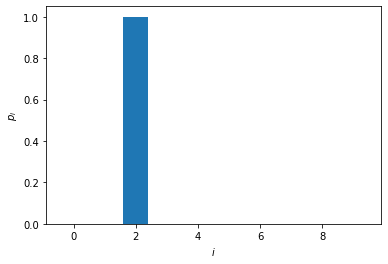

In [8]:
plt.bar(np.arange(cutoff),np.abs(psi)**2)
plt.xlabel("$i$")
plt.ylabel(r"$p_i$")
plt.show()

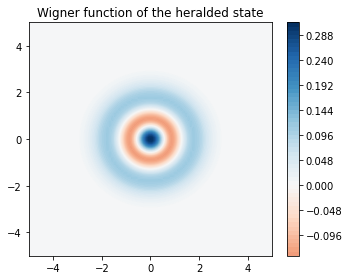

In [9]:
grid = 100
xvec = np.linspace(-5,5,grid)
Wp = wigner(Qobj(psi), xvec, xvec)
wmap = wigner_cmap(Wp)
sc1 = np.max(Wp)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
plt1 = axes.contourf(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes.set_title("Wigner function of the heralded state");
cb1 = fig.colorbar(plt1, ax=axes)
fig.tight_layout()
plt.show()

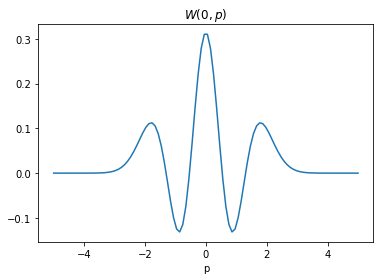

In [10]:
plt.plot(xvec, Wp[:,grid//2])
plt.title(r"$W(0,p)$")
plt.xlabel(r"p")
plt.show()

In [11]:
eta_vals = np.arange(1.,0.45,-0.05)
fidelities = np.zeros_like(eta_vals)
success_p = np.zeros_like(eta_vals)
nmodes = 2
for i,eta in enumerate(eta_vals):
    prog = sf.Program(nmodes)
    eng = sf.Engine("gaussian")
    with prog.context as q:
        S2gate(r)|q
        LossChannel(eta)|q[1]
    state = eng.run(prog).state
    mu = state.means()
    cov = state.cov()
    rho = density_matrix(mu, cov, post_select={1:n}, normalize=False, cutoff=cutoff)
    success_p[i] = np.real_if_close(np.trace(rho))
    fidelities[i] = np.real_if_close(psi.conj() @ rho @ psi/success_p[i])

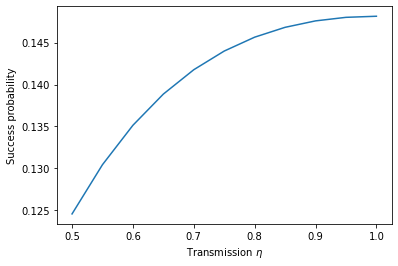

In [12]:
plt.plot(eta_vals, success_p)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Success probability")
plt.show()

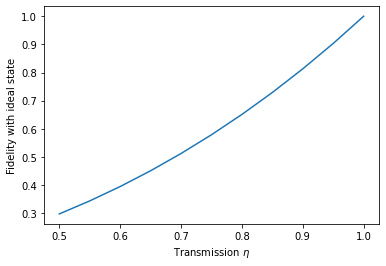

In [13]:
plt.plot(eta_vals, fidelities)
plt.xlabel(r"Transmission $\eta$")
plt.ylabel(r"Fidelity with ideal state")
plt.show()

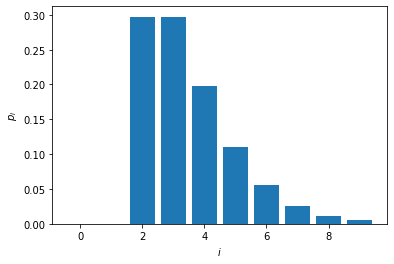

In [14]:
plt.bar(np.arange(cutoff),np.real_if_close(np.diag(rho/np.trace(rho))))
plt.xlabel(r"$i$")
plt.ylabel(r"$p_i$")
plt.show()

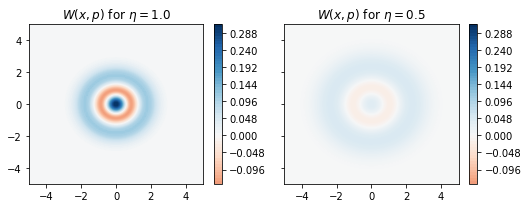

In [15]:
sc1 = np.max(Wp)
W = wigner(Qobj(rho/np.trace(rho)), xvec, xvec)
nrm = mpl.colors.Normalize(-sc1, sc1)
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3),sharey=True)
axes[0].contourf(xvec, xvec, Wp, 60,cmap=cm.RdBu, norm=nrm)
axes[0].contour(xvec, xvec, Wp, 60,  cmap=cm.RdBu, norm=nrm)
axes[0].set_title(r"$W(x,p)$ for $\eta = 1.0$");
cb1 = fig.colorbar(plt1, ax=axes[0])
plt2 = axes[1].contourf(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)
plt2 = axes[1].contour(xvec, xvec, W ,60, cmap=cm.RdBu, norm=nrm)
axes[1].set_title(r"$W(x,p)$ for $\eta = 0.5$");
cb2 = fig.colorbar(plt1, ax=axes[1])
fig.tight_layout()
plt.show()

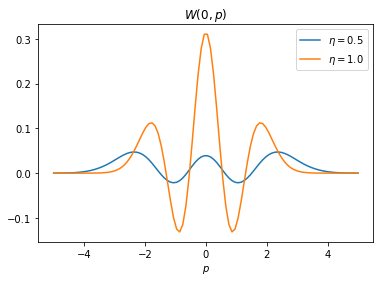

In [16]:
plt.plot(xvec, W[:,grid//2], label=r"$\eta=0.5$")
plt.plot(xvec, Wp[:,grid//2], label=r"$\eta=1.0$")
plt.title(r"$W(0,p)$")
plt.xlabel(r"$p$")
plt.legend()
plt.show()